### Statistical inference


In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
#from scipy.integrate import odeint
import mplcyberpunk
import tqdm
#from functions import nth_derivative
import pandas as pd
from scipy.integrate import quad
from scipy.optimize import minimize

In [2]:
#plt.style.use('cyberpunk')

In [3]:
cov=np.loadtxt('cov_mu.txt', skiprows=0)

In [4]:
cov.shape

(31, 31)

In [5]:
#cov=cov.reshape((31,31))

In [6]:
# shoes=pd.read_csv('pantheon+_lcparam_full_long_zhel.txt')
shoes=np.loadtxt('datos_mu.txt')
shoes.shape

(31, 2)

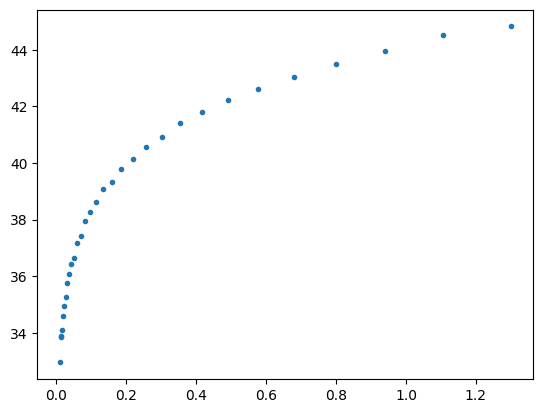

In [7]:
redshift=shoes[:,0].reshape(-1,1)
mu=shoes[:,1].reshape(-1,1)

plt.plot(redshift, mu, '.')

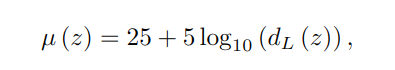

In [ ]:
#importing model
nodos=20
ANN =  nn.Sequential(nn.Linear(3, nodos), nn.Tanh(), nn.Linear(nodos,nodos),
                    nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    # nn.Tanh(), nn.Linear(nodos,nodos)
                    nn.Tanh(),nn.Linear(nodos,1))

ANN.load_state_dict(torch.load('CPL_param_dict_50'))
ANN.eval()

Sequential(
  (0): Linear(in_features=3, out_features=20, bias=True)
  (1): Tanh()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Tanh()
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Tanh()
  (6): Linear(in_features=20, out_features=1, bias=True)
)

In [9]:
#The reparametrization of the neuralnetwork 7
zi=0.0
def Param(T,net=ANN,ti=zi):
    out = net(T)
    b=1-torch.exp(ti-T[:,0].view(-1,1))
    return 0.0 + b.view(-1,1)*out

In [10]:
#the dL distance from the neural network
z = torch.tensor(redshift, dtype=float)

def ANN_dL(omegas):
    T = torch.cat((z, omegas[0] * torch.ones_like(z), omegas[1] * torch.ones_like(z)), 1)
    T = T.to(torch.float)
    return 1/67.0*(1+z)*Param(T).detach()
    

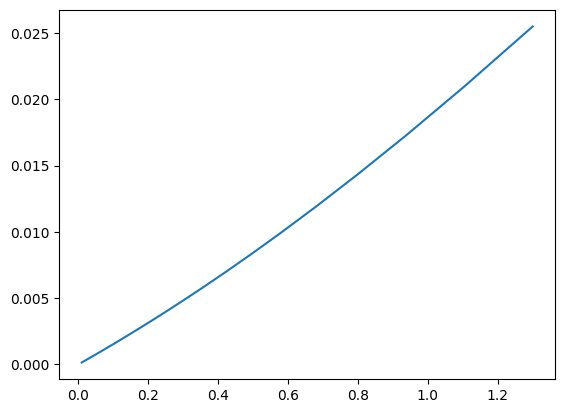

In [11]:
plt.plot(redshift,ANN_dL([0,-1]))

In [12]:
#Y ahora la DL numérica
Omega_m0 = 0.3
Omega_Lambda0 = 0.7
#omega_0, omega_a = 1,1

zi=0.0
#zf=3.0

def integrand(z1, omega_0, omega_a):
    return 1 / np.sqrt(Omega_m0 * (1 + z1)**3 + Omega_Lambda0 * (1 + z1)**(3 * (1 + omega_0 + omega_a)) * np.exp(-3 * omega_a * z1 / (1 + z1)))

def DL(omegas):
    dis=np.zeros_like(redshift)
    for i,z0 in enumerate(redshift):
        dis[i],_=quad(integrand, zi, z0,args=(omegas[0], omegas[1]))
    return 1/67.0*(1+redshift)*dis  


map_0=1
map_a=1

def DL_map(z):
    #dis=np.zeros_like(redshift)
    dis,_ = quad(integrand, zi, z,args=(map_0, map_a))
    return 1/67.0*(1+z)*dis 

In [13]:
%%timeit 
map_0=1
map_a=1
np.array(list(map(DL_map, redshift)))

4.52 ms ± 222 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
%%timeit 
DL([1,1])


4.65 ms ± 494 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
%%timeit
ANN_dL([1,1])

457 µs ± 16.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


La versión del ciclo for es más práctica para evaluar distintas combinaciones de parámetros w_0, w_a.

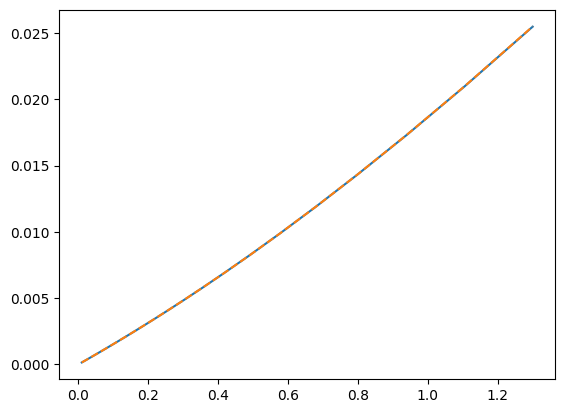

In [16]:
plt.plot(redshift, DL([0,-1]))
plt.plot(redshift, ANN_dL([0,-1]),'--')

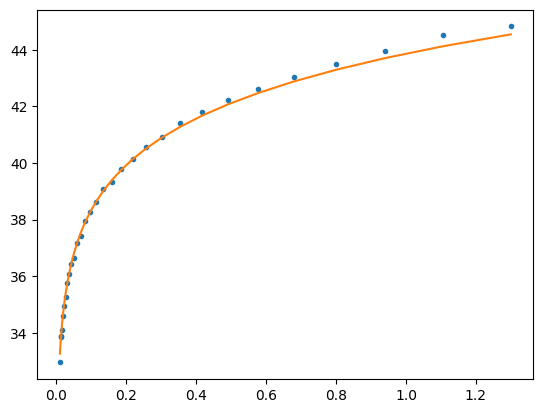

In [17]:
#Ahora veamos si es capaz de ajsutar el módulo de distancia, tanto el numérico como la red
plt.plot(redshift,mu,'.')
plt.plot(redshift, 25+5*np.log10(3e5*ANN_dL([-3.444e-01 ,-1.789e-01])))
#plt.plot(redshift, 25+5*np.log10(3e5*ANN_dL([1,-1.0])))

Existen basicamente dos maneras de evaluar el likelihood utilizando la red neuronal, el primero es evaluar punto por punto sobre z, para una misma combinación de parámetros libres.

El otro, es completar un arreglo con todos los z y los respectivos parámetros y evlauarlos en una sola propagación hacia delante.

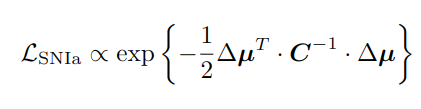

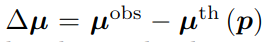

In [18]:
%%timeit 
MU = 25+5*np.log10(3e5*DL([1,1]))
d_mu = mu-MU
#type(d_mu[0,0])
np.dot(np.linalg.inv(cov),d_mu)
#np.dot(np.linalg.inv(cov),d_mu)
#np.dot(d_mu.T, np.dot(np.linalg.inv(cov),d_mu))

6.44 ms ± 536 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
mutensor=torch.tensor(mu)
covtensor=torch.tensor(cov)

In [20]:
%%timeit 
MU=25+5*np.log10(3e5*ANN_dL([1,1]))
d_mu = mutensor-MU
#type(d_mu[0,0])
torch.matmul(d_mu.T,torch.matmul(torch.linalg.inv(covtensor),d_mu)).numpy()

#np.dot(d_mu.T, np.dot(np.linalg.inv(cov),d_mu))

927 µs ± 138 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [21]:
omega0, omegaa = 1,1

In [22]:
%timeit 25+5*np.log10(3e5*DL([omega0, omegaa]))

4.17 ms ± 132 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
def L_ANN(omegas):
    MU=25+5*np.log10(3e5*ANN_dL(omegas))
    d_mu = mutensor-MU
    exp = torch.matmul(d_mu.T,torch.matmul(torch.linalg.inv(covtensor),d_mu)).numpy()
    return 0.5*exp 

In [24]:
# def L_ANN(omegas):
#     MU=25+5*np.log10(3e5*ANN_dL(omegas))
#     d_mu = mu-MU.numpy()
#     #exp = np.dot(d_mu.T, np.dot(np.linalg.inv(cov),d_mu))
#     return np.sum(d_mu**2)/np.var(mu)

In [25]:
# bnds = ((-3, 3), (-3, 3))
# minimize(L_ANN,[0.5,0.5], bounds=bnds)

In [26]:
L_ANN([5,5])

array([[5554.0074772]])

In [27]:
# #hacemos la inferencia
# from scipy.stats import multivariate_normal
# from scipy.stats import chi2

# def metropolis_hastings(L_ANN, omega0, omegaa, steps, sigma):
#   # Inicializar variables
#   omega_actual = np.array([omega0, omegaa])
#   mejores_omegas = []
  
#   for _ in range(steps):
#     # Proponer un nuevo estado
#     omega_propuesto = omega_actual + np.random.normal(0, sigma, 2)
    
#     # Calcular la razón de aceptación
#     ratio = L_ANN(omega_propuesto) / L_ANN(omega_actual)
    
#     # Aceptar o rechazar el nuevo estado
#     if ratio <= 1:
#       omega_actual = omega_propuesto
#     else:
#       u = np.random.uniform(0, 1)
#       if u > ratio:
#         omega_actual = omega_propuesto
    
#     # Almacenar el mejor estado
#     mejores_omegas.append(omega_actual.copy())
  
#   return mejores_omegas

In [28]:
def metropolis_hastings(L_ANN, omega0, omegaa, steps, sigma):
  # Inicializar variables
  omega_actual = np.array([omega0, omegaa])
  mejores_omegas = []
  todos_omegas = []
  
  for _ in range(steps):
    # Proponer un nuevo estado
    omega_propuesto = omega_actual + np.random.normal(0, sigma, 2)
    
    # Calcular la razón de aceptación
    ratio = L_ANN(omega_propuesto) / L_ANN(omega_actual)
    
    # Aceptar o rechazar el nuevo estado
    if ratio <= 1:
      omega_actual = omega_propuesto
      #todos_omegas.append(omega_actual.copy())

    else:
      #todos_omegas.append(omega_propuesto.copy())
      u = np.random.uniform(0, 1)
      if u < 0.1:
        omega_actual = omega_propuesto
    
    # Almacenar el mejor estado
    mejores_omegas.append(omega_actual.copy())

    # #Almacenar la cadena
    # todos_omegas.append(omega_actual.copy())
  
  return mejores_omegas

# def dibujar_entornos_confianza(mejores_omegas, limites):
#   # Crear la gráfica
#   plt.figure()
  
#   # Dibujar los puntos
#   for omega in mejores_omegas:
#     plt.plot(omega[0], omega[1], 'o')
  
#   # Calcular y dibujar los entornos de confianza
#   # (Ejemplo: utilizar desviaciones estándar)
#   std_x = np.std([omega[0] for omega in mejores_omegas])
#   std_y = np.std([omega[1] for omega in mejores_omegas])
  
#   plt.fill_between(
#     [limites[0], limites[1]],
#     [omega[1] - std_y for omega in mejores_omegas],
#     [omega[1] + std_y for omega in mejores_omegas],
#     alpha=0.2,
#     color='blue'
#   )
  
#   # Mostrar la gráfica
#   plt.show()

# # Ejemplo de uso
# omega0 = [0.1, 0.2]
# omegaa = [0.3, 0.4]
# steps = 1000
# sigma = 0.1

# mejores_omegas = metropolis_hastings(L_ANN, omega0, omegaa, steps, sigma)
# limites = [0, 1]  # Límites del espacio de búsqueda

# dibujar_entornos_confianza(mejores_omegas, limites)

In [29]:
def graficar_regiones_confianza(mejores_omegas):
  # Calcular la matriz de covarianza
  cov = np.cov(np.array(mejores_omegas).T)
  
  # Generar puntos para la elipse de confianza
  puntos_elipse = []
  for theta in np.linspace(0, 2*np.pi, 100):
    punto = np.array([0, 0]) + 2 * np.sqrt(chi2(0.95, 2)) * np.dot(np.linalg.eig(cov)[1], np.array([np.cos(theta), np.sin(theta)]))
    puntos_elipse.append(punto)
  
  # Graficar
  plt.scatter([omega[0] for omega in mejores_omegas], [omega[1] for omega in mejores_omegas], c='b', alpha=0.5)
  plt.plot([punto[0] for punto in puntos_elipse], [punto[1] for punto in puntos_elipse], c='r')
  plt.xlabel('omega0')
  plt.ylabel('omegaa')
  plt.show()


In [30]:
# Parámetros
omega0 = 0
omegaa = 0
steps = 1000
sigma = 0.1

# Ejecutar Metropolis-Hastings


# Graficar regiones de confianza
#graficar_regiones_confianza(mejores_omegas)


In [31]:
#tiempo de la red
%timeit mejores_omegas = metropolis_hastings(L_ANN, omega0, omegaa, steps, sigma)

1.89 s ± 42.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [32]:
mejores_omegas = metropolis_hastings(L_ANN, omega0, omegaa, steps, sigma)

In [33]:
np.array(mejores_omegas)[-1]

array([-0.44425367, -2.01461965])

In [34]:
L_ANN(np.array(mejores_omegas)[-1])

array([[22.07308128]])

Text(0, 0.5, '$\\mu_{\\mathcal{\\Psi}}$')

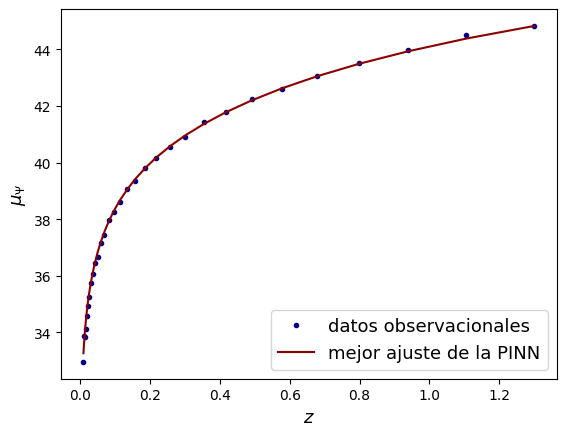

In [35]:
#Ahora veamos si es capaz de ajsutar el módulo de distancia, tanto el numérico como la red
plt.plot(redshift,mu,'.', color='darkblue', label='datos observacionales')
plt.plot(redshift, 25+5*np.log10(3e5*ANN_dL(mejores_omegas[-1])), color='darkred', label='mejor ajuste de la PINN')
plt.legend(fontsize=13)
plt.xlabel('$z$', size=13)
plt.ylabel('$\mu_{\mathcal{\Psi}}$', size = 13)
#plt.savefig('ajuste_mu_pinn.pdf')


In [36]:
# Ahora la inferencia con el método numérico
def L_DL(omegas):
    MU=25+5*np.log10(3e5*DL(omegas))
    d_mu = mu-MU
    exp = np.dot(d_mu.T, np.dot(np.linalg.inv(cov),d_mu))
    return 0.59*exp

In [37]:
%timeit omegas_DL = metropolis_hastings(L_DL, omega0, omegaa, steps, sigma) 

KeyboardInterrupt: 

In [38]:
omegas_DL = metropolis_hastings(L_DL, omega0, omegaa, steps, sigma) 

In [39]:
L_DL(np.array(omegas_DL)[-1])

array([[25.1996371]])

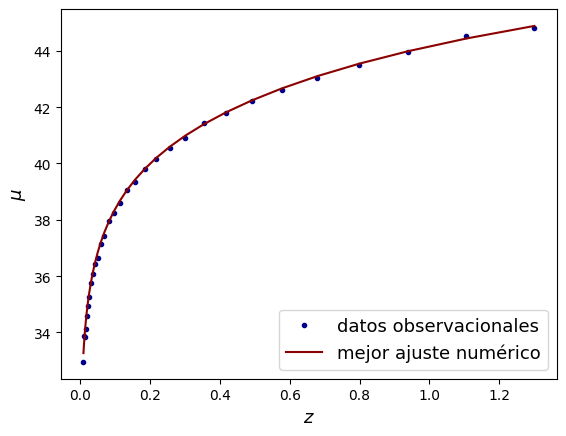

In [40]:
plt.plot(redshift,mu,'.', color='darkblue', label='datos observacionales')
plt.plot(redshift, 25+5*np.log10(3e5*DL(omegas_DL[-1])), color='darkred', label='mejor ajuste numérico')
plt.xlabel('$z$', size=13)
plt.ylabel('$\mu$', size = 13)
plt.legend(fontsize=13)
#plt.savefig('ajuste_mu_numeric.pdf')

In [41]:
# def f(x, y):
#     return np.sin(np.sqrt(x ** 2 + y ** 2))

o0 = np.linspace(-2.5, 2.5, 50)
oa = np.linspace(-2.5, 2.5, 50)

O0, Oa = np.meshgrid(o0, oa)
#Z = f(X, Y)
imag=np.ones_like(O0)

for i,x in enumerate(o0):
    for j,y in enumerate(oa):
        imag[i,j]=L_ANN([x,y])
        #print([x,y])
        


/tmp/ipykernel_11806/857560447.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  imag[i,j]=L_ANN([x,y])


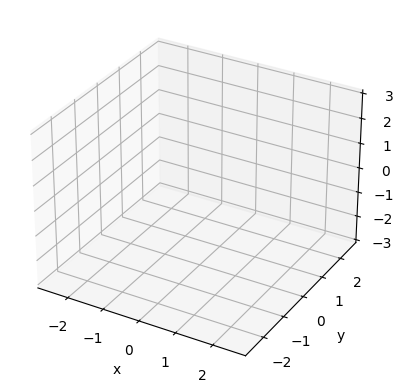

In [42]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(O0, Oa, imag, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_zlim(-3, 3);

In [44]:
def graficar_segmentos(A, titulo:str):
  """
  Grafica los segmentos de línea que unen los puntos en el array A.

  Args:
    A: Un array de vectores, donde cada vector tiene dos elementos.

  Returns:
    None.
  """

  # Obtener las coordenadas de los puntos
  x = A[:, 0]
  y = A[:, 1]
  
  
  # Graficar los segmentos de línea
  for i in range(len(A) - 1):
    plt.plot([x[i], x[i + 1]], [y[i], y[i + 1]], '-', label=titulo, color='teal')
    #if i==100: plt.plot([x[i], x[i + 1]], [y[i], y[i + 1]], 'o-', label=titulo, color='darkred')
  plt.xlabel('$\omega_0$', size=16)
  plt.ylabel('$\omega_a$', size=16)
  
  
  # Mostrar la gráfica
  plt.title(titulo)
  #mplcyberpunk.make_lines_glow();
  # plt.savefig('metodo_pinn_1.png')
  # plt.savefig('metodo_pinn_1.pdf')
  plt.grid()
  plt.show()
  plt.legend()

In [46]:
A=np.array(omegas_DL)

Intervalo de confianza al 68% para omega_0: (-0.6146738391122876, -0.460725857212401)
Intervalo de confianza al 68% para omega_a: (-2.455351211878341, -1.3853878536481374)
Intervalo de confianza al 95% para omega_0: (-0.7233322941495066, -0.3749650564621481)
Intervalo de confianza al 95% para omega_a: (-2.8948799672569, -0.4213460235810444)
Valor máximo de Z: 10.857236387644265


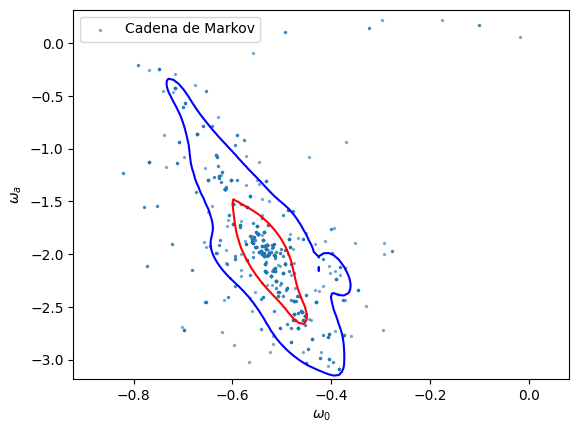

In [53]:
# import numpy as np
# import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# # Cargar la cadena de Markov A
# A = np.array([[-0.0176667 ,  0.06312659],
#               [-0.10001593,  0.17050043],
#               [-0.10001593,  0.17050043],
#               # (continuar con los demás valores de la cadena)
#               [-0.53331471, -2.16240198],
#               [-0.53331471, -2.16240198]])
# Separar los parámetros omega_0 y omega_a
omega_0_chain = A[:, 0]
omega_a_chain = A[:, 1]

# Función para calcular los intervalos de confianza
def confidence_intervals(chain, level=0.68):
    sorted_chain = np.sort(chain)
    lower_idx = int((1 - level) / 2 * len(sorted_chain))
    upper_idx = int((1 + level) / 2 * len(sorted_chain))
    return sorted_chain[lower_idx], sorted_chain[upper_idx]

# Calcular intervalos de confianza al 68% y 95%
omega_0_68 = confidence_intervals(omega_0_chain, level=0.68)
omega_a_68 = confidence_intervals(omega_a_chain, level=0.68)
omega_0_95 = confidence_intervals(omega_0_chain, level=0.95)
omega_a_95 = confidence_intervals(omega_a_chain, level=0.95)

# Mostrar resultados de intervalos de confianza
print(f"Intervalo de confianza al 68% para omega_0: {omega_0_68}")
print(f"Intervalo de confianza al 68% para omega_a: {omega_a_68}")
print(f"Intervalo de confianza al 95% para omega_0: {omega_0_95}")
print(f"Intervalo de confianza al 95% para omega_a: {omega_a_95}")

# Gráfica de las regiones de confianza
fig, ax = plt.subplots()
ax.scatter(omega_0_chain, omega_a_chain, s=2, label='Cadena de Markov', alpha=0.5)

# Graficar los contornos de las regiones de confianza
kde = gaussian_kde(A.T)
xmin, xmax = omega_0_chain.min() - 0.1, omega_0_chain.max() + 0.1
ymin, ymax = omega_a_chain.min() - 0.1, omega_a_chain.max() + 0.1
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kde(positions).T, X.shape)

# Revisar el valor máximo de Z
z_max = Z.max()
print(f"Valor máximo de Z: {z_max}")

# Ajustar los niveles de contorno asegurando que estén en orden creciente
contour_levels = [z_max * 0.05, z_max * 0.32]

# Graficar contornos para el 68% y 95%
ax.contour(X, Y, Z, levels=contour_levels, colors=['blue', 'red'])

# Etiquetas y leyenda
ax.set_xlabel(r'$\omega_0$')
ax.set_ylabel(r'$\omega_a$')
ax.legend(['Cadena de Markov', '68% C.L.', '95% C.L.'])
#plt.show()

Intervalo de confianza al 68% para omega_0: (-0.6146738391122876, -0.460725857212401)
Intervalo de confianza al 68% para omega_a: (-2.455351211878341, -1.3853878536481374)
Intervalo de confianza al 95% para omega_0: (-0.7233322941495066, -0.3749650564621481)
Intervalo de confianza al 95% para omega_a: (-2.8948799672569, -0.4213460235810444)
Valor máximo de Z: 10.857236387644265


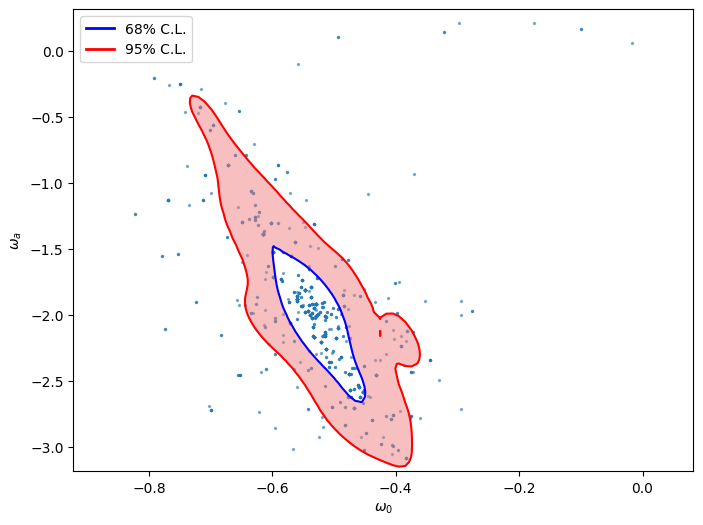

In [59]:
# Separar los parámetros omega_0 y omega_a
omega_0_chain = A[:, 0]
omega_a_chain = A[:, 1]

# Función para calcular los intervalos de confianza
def confidence_intervals(chain, level=0.68):
    sorted_chain = np.sort(chain)
    lower_idx = int((1 - level) / 2 * len(sorted_chain))
    upper_idx = int((1 + level) / 2 * len(sorted_chain))
    return sorted_chain[lower_idx], sorted_chain[upper_idx]

# Calcular intervalos de confianza al 68% y 95%
omega_0_68 = confidence_intervals(omega_0_chain, level=0.68)
omega_a_68 = confidence_intervals(omega_a_chain, level=0.68)
omega_0_95 = confidence_intervals(omega_0_chain, level=0.95)
omega_a_95 = confidence_intervals(omega_a_chain, level=0.95)

# Mostrar resultados de intervalos de confianza
print(f"Intervalo de confianza al 68% para omega_0: {omega_0_68}")
print(f"Intervalo de confianza al 68% para omega_a: {omega_a_68}")
print(f"Intervalo de confianza al 95% para omega_0: {omega_0_95}")
print(f"Intervalo de confianza al 95% para omega_a: {omega_a_95}")

# Gráfica de las regiones de confianza
fig, ax = plt.subplots(figsize=(8, 6))  # Aumentar tamaño de la figura
ax.scatter(omega_0_chain, omega_a_chain, s=2, label='Cadena de Markov', alpha=0.5)

# Graficar los contornos de las regiones de confianza
kde = gaussian_kde(A.T)
xmin, xmax = omega_0_chain.min() - 0.1, omega_0_chain.max() + 0.1
ymin, ymax = omega_a_chain.min() - 0.1, omega_a_chain.max() + 0.1
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kde(positions).T, X.shape)

# Revisar el valor máximo de Z
z_max = Z.max()
print(f"Valor máximo de Z: {z_max}")

# Asegurarse de que los niveles estén en orden creciente
contour_levels = [z_max * 0.05, z_max * 0.32]

# Graficar contornos para el 68% y 95%, rellenando las áreas
contours = ax.contourf(X, Y, Z, levels=contour_levels, colors=['lightcoral', 'lightblue'], alpha=0.5)
contour_lines = ax.contour(X, Y, Z, levels=contour_levels, colors=['red', 'blue'])

# Añadir barra de color opcional (puedes comentar esto si no la quieres)
#fig.colorbar(contours, ax=ax, label='Densidad de probabilidad')

# Etiquetas y leyenda
ax.set_xlabel(r'$\omega_0$')
ax.set_ylabel(r'$\omega_a$')

# Ajustar la leyenda manualmente
handles = [plt.Line2D([0], [0], color='blue', lw=2),
           plt.Line2D([0], [0], color='red', lw=2)]
labels = ['68% C.L.', '95% C.L.']
ax.legend(handles, labels)

plt.show()

Intervalo de confianza al 68% para omega_0: (-0.6146738391122876, -0.460725857212401)
Intervalo de confianza al 68% para omega_a: (-2.455351211878341, -1.3853878536481374)
Intervalo de confianza al 95% para omega_0: (-0.7233322941495066, -0.3749650564621481)
Intervalo de confianza al 95% para omega_a: (-2.8948799672569, -0.4213460235810444)
Valor máximo de Z: 10.857236387644265


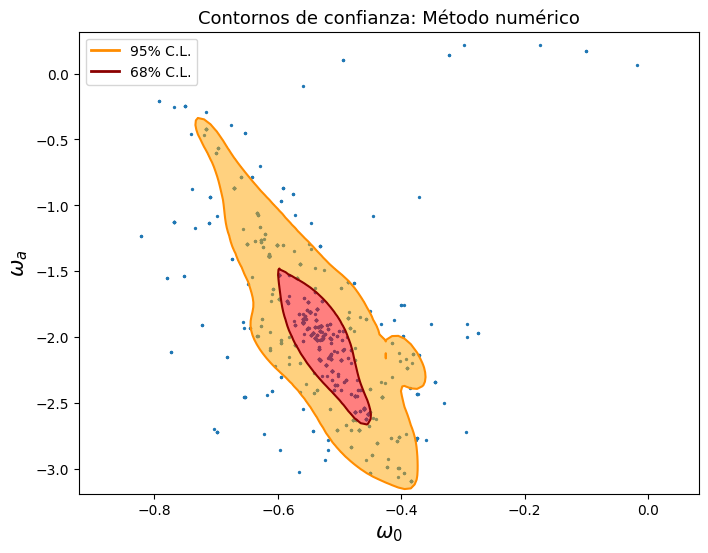

In [89]:
# Separar los parámetros omega_0 y omega_a método numérico
omega_0_chain = A[:, 0]
omega_a_chain = A[:, 1]

# Función para calcular los intervalos de confianza
def confidence_intervals(chain, level=0.68):
    sorted_chain = np.sort(chain)
    lower_idx = int((1 - level) / 2 * len(sorted_chain))
    upper_idx = int((1 + level) / 2 * len(sorted_chain))
    return sorted_chain[lower_idx], sorted_chain[upper_idx]

# Calcular intervalos de confianza al 68% y 95%
omega_0_68 = confidence_intervals(omega_0_chain, level=0.68)
omega_a_68 = confidence_intervals(omega_a_chain, level=0.68)
omega_0_95 = confidence_intervals(omega_0_chain, level=0.95)
omega_a_95 = confidence_intervals(omega_a_chain, level=0.95)

# Mostrar resultados de intervalos de confianza
print(f"Intervalo de confianza al 68% para omega_0: {omega_0_68}")
print(f"Intervalo de confianza al 68% para omega_a: {omega_a_68}")
print(f"Intervalo de confianza al 95% para omega_0: {omega_0_95}")
print(f"Intervalo de confianza al 95% para omega_a: {omega_a_95}")

# Gráfica de las regiones de confianza
fig, ax = plt.subplots(figsize=(8, 6))  # Aumentar tamaño de la figura
ax.scatter(omega_0_chain, omega_a_chain, s=2, label='Cadena de Markov')

# Graficar los contornos de las regiones de confianza
kde = gaussian_kde(A.T)
xmin, xmax = omega_0_chain.min() - 0.1, omega_0_chain.max() + 0.1
ymin, ymax = omega_a_chain.min() - 0.1, omega_a_chain.max() + 0.1
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kde(positions).T, X.shape)

# Revisar el valor máximo de Z
z_max = Z.max()
print(f"Valor máximo de Z: {z_max}")

# Asegurarse de que los niveles estén en orden creciente
contour_levels = [z_max * 0.05, z_max * 0.32, z_max]  # Incluimos z_max para que el nivel más alto también esté lleno

# Graficar contornos para el 68% y 95%, rellenando las áreas
contours = ax.contourf(X, Y, Z, levels=contour_levels, colors=['orange', 'red', 'none'], alpha=0.5)
contour_lines = ax.contour(X, Y, Z, levels=contour_levels[:-1], colors=['darkorange', 'darkred'])

# Añadir barra de color opcional (puedes comentar esto si no la quieres)
#fig.colorbar(contours, ax=ax, label='Densidad de probabilidad')

# Etiquetas y leyenda
ax.set_xlabel(r'$\omega_0$', size=15)
ax.set_ylabel(r'$\omega_a$', size=15)

# Ajustar la leyenda manualmente
handles = [plt.Line2D([0], [0], color='darkorange', lw=2),
           plt.Line2D([0], [0], color='darkred', lw=2)]
labels = ['95% C.L.', '68% C.L.']
ax.legend(handles, labels)
ax.set_title('Contornos de confianza: Método numérico', size=13)

fig.savefig('contornos_confianza_CPL_num.pdf', format='pdf', dpi=300)
fig.savefig('contornos_confianza_CPL_num.png', format='png', dpi=300)

# plt.savefig('contornos_confianza_CPL_num.pdf')
# plt.savefig('contornos_confianza_CPL_num.png')

Intervalo de confianza al 68% para omega_0: (-0.6363869311832434, -0.5081393027096626)
Intervalo de confianza al 68% para omega_a: (-2.110075965366731, -1.130977585105559)
Intervalo de confianza al 95% para omega_0: (-0.7393635613127387, -0.3862895996173733)
Intervalo de confianza al 95% para omega_a: (-2.2946872318742666, -0.6061003548662268)
Valor máximo de Z: 11.976584330510613


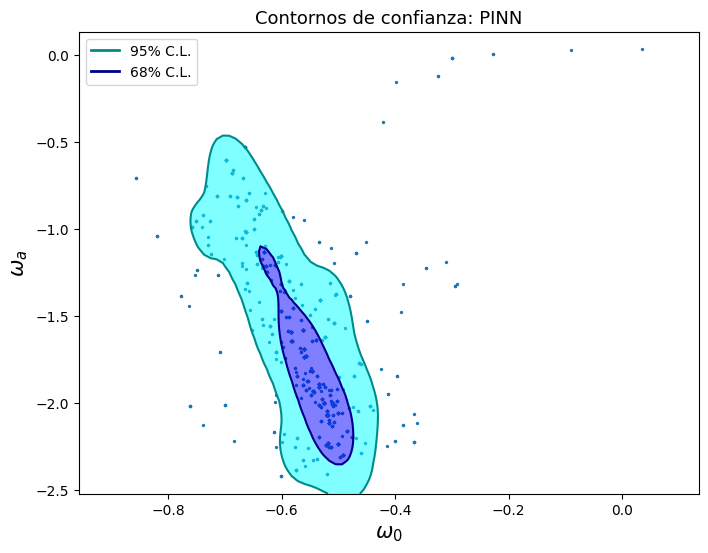

In [90]:
# Separar los parámetros omega_0 y omega_a PINN
B= np.array(mejores_omegas)
omega_0_chain = B[:, 0]
omega_a_chain = B[:, 1]

# Función para calcular los intervalos de confianza
def confidence_intervals(chain, level=0.68):
    sorted_chain = np.sort(chain)
    lower_idx = int((1 - level) / 2 * len(sorted_chain))
    upper_idx = int((1 + level) / 2 * len(sorted_chain))
    return sorted_chain[lower_idx], sorted_chain[upper_idx]

# Calcular intervalos de confianza al 68% y 95%
omega_0_68 = confidence_intervals(omega_0_chain, level=0.68)
omega_a_68 = confidence_intervals(omega_a_chain, level=0.68)
omega_0_95 = confidence_intervals(omega_0_chain, level=0.95)
omega_a_95 = confidence_intervals(omega_a_chain, level=0.95)

# Mostrar resultados de intervalos de confianza
print(f"Intervalo de confianza al 68% para omega_0: {omega_0_68}")
print(f"Intervalo de confianza al 68% para omega_a: {omega_a_68}")
print(f"Intervalo de confianza al 95% para omega_0: {omega_0_95}")
print(f"Intervalo de confianza al 95% para omega_a: {omega_a_95}")

# Gráfica de las regiones de confianza
fig, ax = plt.subplots(figsize=(8, 6))  # Aumentar tamaño de la figura
ax.scatter(omega_0_chain, omega_a_chain, s=2, label='Cadena de Markov')

# Graficar los contornos de las regiones de confianza
kde = gaussian_kde(B.T)
xmin, xmax = omega_0_chain.min() - 0.1, omega_0_chain.max() + 0.1
ymin, ymax = omega_a_chain.min() - 0.1, omega_a_chain.max() + 0.1
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kde(positions).T, X.shape)

# Revisar el valor máximo de Z
z_max = Z.max()
print(f"Valor máximo de Z: {z_max}")

# Asegurarse de que los niveles estén en orden creciente
contour_levels = [z_max * 0.05, z_max * 0.32, z_max]  # Incluimos z_max para que el nivel más alto también esté lleno

# Graficar contornos para el 68% y 95%, rellenando las áreas
contours = ax.contourf(X, Y, Z, levels=contour_levels, colors=['cyan', 'blue', 'none'], alpha=0.5)
contour_lines = ax.contour(X, Y, Z, levels=contour_levels[:-1], colors=['darkcyan', 'darkblue'])

# Añadir barra de color opcional (puedes comentar esto si no la quieres)
#fig.colorbar(contours, ax=ax, label='Densidad de probabilidad')

# Etiquetas y leyenda
ax.set_xlabel(r'$\omega_0$', size=15)
ax.set_ylabel(r'$\omega_a$', size=15)

# Ajustar la leyenda manualmente
handles = [plt.Line2D([0], [0], color='darkcyan', lw=2),
           plt.Line2D([0], [0], color='darkblue', lw=2)]
labels = ['95% C.L.', '68% C.L.']
ax.legend(handles, labels)
ax.set_title('Contornos de confianza: PINN', size=13)

fig.savefig('contornos_confianza_CPL_PINN.pdf', format='pdf', dpi=300)
fig.savefig('contornos_confianza_CPL_PINN.png', format='png', dpi=300)

# plt.show()

# plt.savefig('contornos_confianza_CPL_PINN.pdf')
# plt.savefig('contornos_confianza_CPL_PINN.png')

Valor máximo de Z: 11.976584330510613


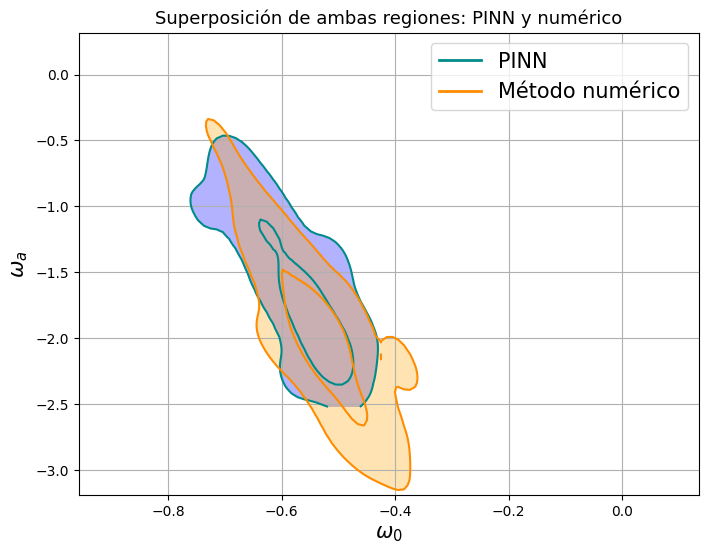

In [101]:
omega_0_chain_1= A[:, 0]
omega_a_chain_1 = A[:, 1]

# Función para calcular los intervalos de confianza
def confidence_intervals(chain, level=0.68):
    sorted_chain = np.sort(chain)
    lower_idx = int((1 - level) / 2 * len(sorted_chain))
    upper_idx = int((1 + level) / 2 * len(sorted_chain))
    return sorted_chain[lower_idx], sorted_chain[upper_idx]

# Calcular intervalos de confianza al 68% y 95%
omega_0_68_1 = confidence_intervals(omega_0_chain_1, level=0.68)
omega_a_68_1 = confidence_intervals(omega_a_chain_1, level=0.68)
omega_0_95_1 = confidence_intervals(omega_0_chain_1, level=0.95)
omega_a_95_1 = confidence_intervals(omega_a_chain_1, level=0.95)

# Mostrar resultados de intervalos de confianza
# print(f"Intervalo de confianza al 68% para omega_0: {omega_0_68}")
# print(f"Intervalo de confianza al 68% para omega_a: {omega_a_68}")
# print(f"Intervalo de confianza al 95% para omega_0: {omega_0_95}")
# print(f"Intervalo de confianza al 95% para omega_a: {omega_a_95}")

# Gráfica de las regiones de confianza
# fig, ax = plt.subplots(figsize=(8, 6))  # Aumentar tamaño de la figura
# ax.scatter(omega_0_chain, omega_a_chain, s=2, label='Cadena de Markov')

# Graficar los contornos de las regiones de confianza
kde_1 = gaussian_kde(A.T)
xmin_1, xmax_1 = omega_0_chain_1.min() - 0.1, omega_0_chain_1.max() + 0.1
ymin_1, ymax_1 = omega_a_chain_1.min() - 0.1, omega_a_chain_1.max() + 0.1
X_1, Y_1 = np.mgrid[xmin_1:xmax_1:100j, ymin_1:ymax_1:100j]
positions_1 = np.vstack([X_1.ravel(), Y_1.ravel()])
Z_1 = np.reshape(kde_1(positions_1).T, X_1.shape)

# Revisar el valor máximo de Z
z_max_1 = Z_1.max()
# print(f"Valor máximo de Z: {z_max}")

# Asegurarse de que los niveles estén en orden creciente
contour_levels_1 = [z_max_1 * 0.05, z_max_1 * 0.32, z_max_1]  # Incluimos z_max para que el nivel más alto también esté lleno

#################################################################################################

# Gráfica de las regiones de confianza
fig, ax = plt.subplots(figsize=(8, 6))  # Aumentar tamaño de la figura
# ax.scatter(omega_0_chain, omega_a_chain, s=2, label='Cadena de Markov')

# Graficar los contornos de las reprint(f"Valor máximo de Z: {z_max}"giones de confianza
kde = gaussian_kde(B.T)
xmin, xmax = omega_0_chain.min() - 0.1, omega_0_chain.max() + 0.1
ymin, ymax = omega_a_chain.min() - 0.1, omega_a_chain.max() + 0.1
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([X.ravel(), Y.ravel()])
Z = np.reshape(kde(positions).T, X.shape)

# Revisar el valor máximo de Z
z_max = Z.max()
print(f"Valor máximo de Z: {z_max}")

# Asegurarse de que los niveles estén en orden creciente
contour_levels = [z_max * 0.05, z_max * 0.32, z_max]  # Incluimos z_max para que el nivel más alto también esté lleno

# Graficar contornos para el 68% y 95%, rellenando las áreas

#PINN
contours = ax.contourf(X, Y, Z, levels=contour_levels, colors=['blue', 'blue', 'none'], alpha=0.3)
contour_lines = ax.contour(X, Y, Z, levels=contour_levels[:-1], colors=['darkcyan', 'darkcyan'])

#Numérico
contours = ax.contourf(X_1, Y_1, Z_1, levels=contour_levels_1, colors=['orange', 'orange', 'none'], alpha=0.3)
contour_lines = ax.contour(X_1, Y_1, Z_1, levels=contour_levels_1[:-1], colors=['darkorange', 'darkorange'])

# Añadir barra de color opcional (puedes comentar esto si no la quieres)
#fig.colorbar(contours, ax=ax, label='Densidad de probabilidad')

# Etiquetas y leyenda
ax.set_xlabel(r'$\omega_0$', size=15)
ax.set_ylabel(r'$\omega_a$', size=15)

# Ajustar la leyenda manualmente
handles = [plt.Line2D([0], [0], color='darkcyan', lw=2),
           plt.Line2D([0], [0], color='darkorange', lw=2)]
labels = ['PINN', 'Método numérico']
ax.legend(handles, labels, fontsize=15)
ax.grid()
ax.set_title('Superposición de ambas regiones: PINN y numérico', size=13)

fig.savefig('ambas_regiones.pdf', format='pdf', dpi=300)
fig.savefig('ambas_regiones.png', format='png', dpi=300)

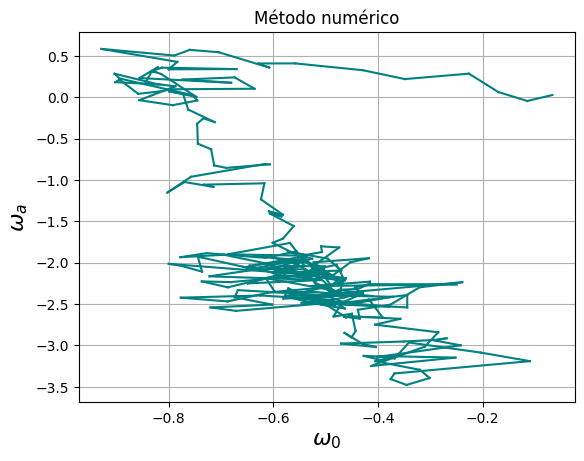

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


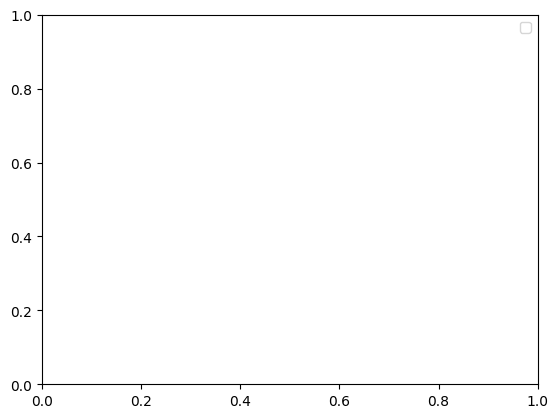

In [58]:
graficar_segmentos(np.array(omegas_DL), 'Método numérico')
#plt.savefig('metro_numeric.png')

In [61]:
np.array(omegas_DL)[-1]

array([-0.41749687, -2.44163402])

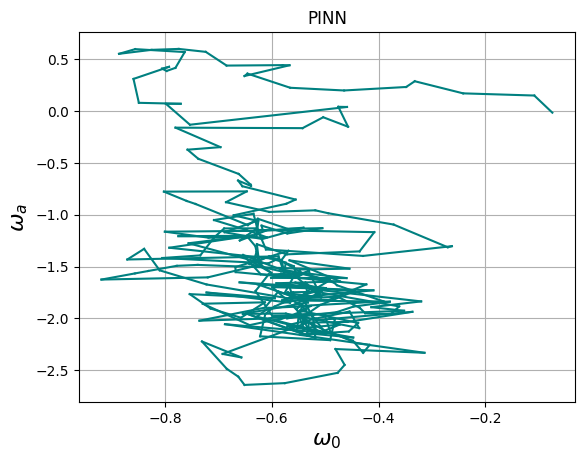

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


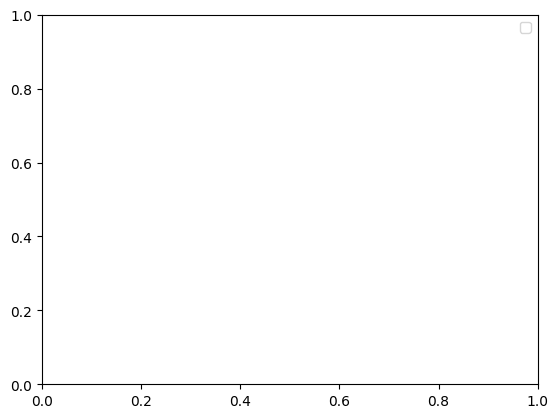

In [62]:
graficar_segmentos(np.array(mejores_omegas), 'PINN')
